In [1]:
import os
import random as r
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as  pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [2]:
device = torch.device("mps")    # cuda, mps, cpu...

In [54]:
class ABMDataset(Dataset):
    def __init__(self, dx, ntypes, directory="csvs", rotate=None):
        # read directory to get simulation CSVs
        csvs = []
        for file in os.listdir(directory):
            if file.startswith("adhesion"):
                csvs.append(file)
        n = len(csvs)

        # size of the simulation space and discrete (image) input
        size = np.array([500,500])
        image_shape = np.array([ntypes, int(size[0]/dx), int(size[1]/dx)], dtype=int)
        M_shape = np.array([2, 2], dtype=int)
        
        # to generate more samples we can rotate the input multiple times
        if rotate is None:
            rotate = 1
        thetas = np.linspace(0, 360, rotate, endpoint=False)
        
        # create holders for all samples (increase size if rotating input)
        self.data = torch.zeros(rotate*n, *image_shape)
        self.labels = torch.zeros(rotate*n, 1, dtype=int)
        self.rotated = [None] * rotate*n

        # additionally hold original agent values
        self.locations = torch.zeros(rotate*n, 1000, 2)
        self.states = torch.zeros(rotate*n, 1000, dtype=int)

        # go through each file
        for i in range(n):
            # read CSV
            agents = np.genfromtxt(f"{directory}/{csvs[i]}", delimiter=',', skip_header=True)

            # get positions/states for all agents
            positions = (agents[:, 0:2] - size/2)    # center points
            states = agents[:, 9].astype(int)

            # rotate across all angles
            for j in range(rotate):
                # get rotation matrix
                theta = thetas[j]
                M = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
                rotated = positions @ M + size/2    # apply rotation and un-center points
                
                self.locations[rotate*i + j] = torch.tensor(rotated)
                self.states[rotate*i + j] = torch.tensor(states)

                # embed agents into discrete space (image)
                for k in range(len(agents)):
                    discrete = (rotated[k] / dx).astype(int)
                    self.data[rotate*i + j][states[k], discrete[0], discrete[1]] += 1

                # get label from file name
                self.labels[rotate*i + j, 0] = int(csvs[i].split("_")[1])

                # save rotation matrix
                self.rotated[rotate*i + j] = M

        # send to device
        self.data = self.data.to(device)
        self.labels = self.labels.to(device)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.rotated[idx]

In [55]:
dx = 10
dataset = ABMDataset(dx=dx, ntypes=2, rotate=20)
print(len(dataset))

10000


In [56]:
batch = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

In [57]:
def make_image(locations, states):
    # create blank image
    image = np.zeros((2000, 2000, 3), dtype=np.uint8)
    
    # go through all agents and draw on image
    for i in range(len(locations)):
        # get color of agent
        if states[i] == 0:
            color = (255, 0, 0)
        else:
            color = (0, 255, 255)

        # get xy coordinates
        x, y = int(4 * locations[i,0]), int(4 * locations[i,1])
        
        # draw the agent and a black outline to distinguish overlapping agents
        image = cv2.ellipse(image, (x, y), (20, 20), 0, 0, 360, color, -1)
        image = cv2.ellipse(image, (x, y), (20, 20), 0, 0, 360, (0, 0, 0), 1)

    # flip to match origin on bottom-left
    image = cv2.flip(image, 0)

    return image

# Baseline Model

In [234]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [235]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [236]:
class VAE(nn.Module):
    def __init__(self, h_dim=1024, z_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, h_dim, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=6, stride=2),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [237]:
def loss_fn(generated, original, mu, logvar):
    BCE = F.mse_loss(generated, original, reduction='sum')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [238]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [251]:
# send to device and turn on training
vae.train()

# training vae
epochs = 1000
for epoch in range(epochs):
    for idx, (original, labels, _) in enumerate(train_loader):

        if idx > 75:
            # run through vae and measure loss with MSE
            generated, mu, logvar = vae(original)
            loss = loss_fn(generated, original, mu, logvar)
    
            # update vae
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss/len(generated)):.3f}")

Epoch[1/1000] Loss: 787.518
Epoch[101/1000] Loss: 797.266
Epoch[201/1000] Loss: 754.384
Epoch[301/1000] Loss: 809.770
Epoch[401/1000] Loss: 822.779
Epoch[501/1000] Loss: 793.098
Epoch[601/1000] Loss: 836.474
Epoch[701/1000] Loss: 812.236
Epoch[801/1000] Loss: 815.275
Epoch[901/1000] Loss: 824.590


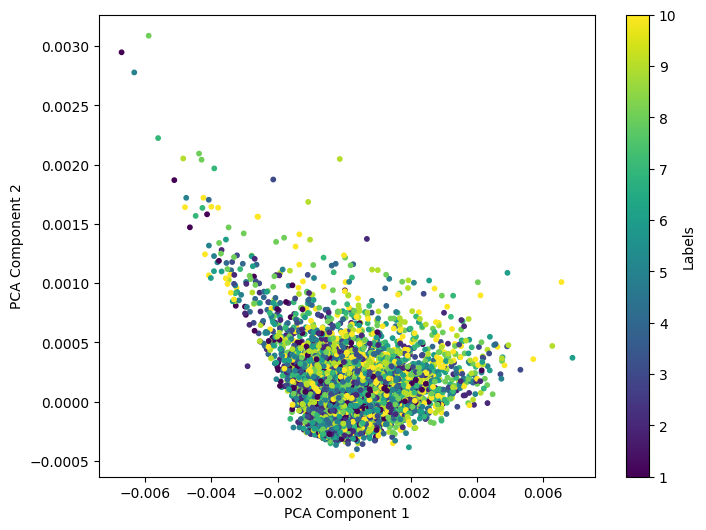

In [252]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
vae.eval()

# Iterate over batches in train loader
for batch_data, batch_labels, _ in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, mu, _ = vae.encode(batch_data.to(device))
    
    # Append mu and labels to the respective lists
    latent_space_representations.append(mu.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.savefig('mean_pca.pdf')
plt.show()

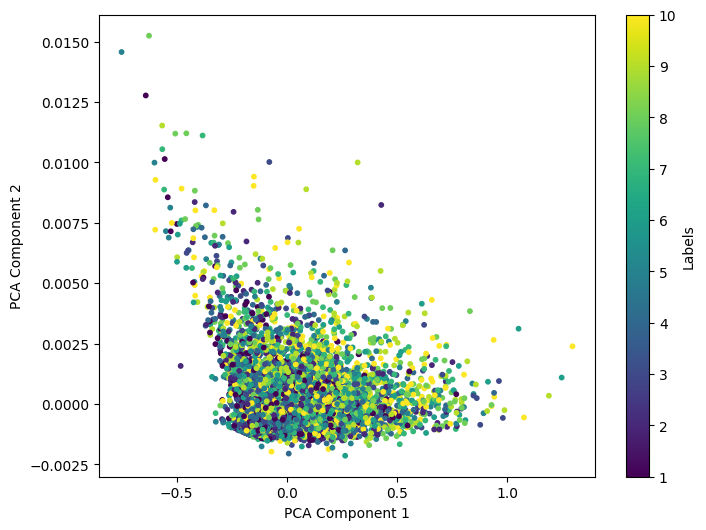

In [256]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
vae.eval()

# Iterate over batches in train loader
for batch_data, batch_labels, _ in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, _, logvar = vae.encode(batch_data.to(device))

    # Append mu and labels to the respective lists
    latent_space_representations.append(logvar.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.savefig('logvar_pca.pdf')
plt.show()


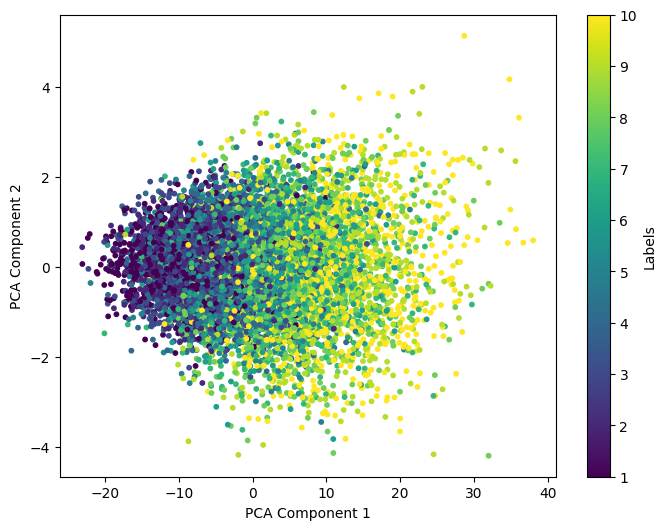

In [445]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
vae.eval()

# Iterate over batches in train loader
for batch_data, batch_labels in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, mu, logvar = vae.encode(batch_data.to(device))

    # Append mu and labels to the respective lists
    merge = torch.cat((mu, logvar), axis=1)
    latent_space_representations.append(merge.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.savefig('logvar_pca.pdf')
plt.show()


In [254]:
torch.save(vae.state_dict(), "vae_2000.pt")

In [89]:
vae = VAE().to(device)
vae.load_state_dict(torch.load("vae_16_lt.pt"))

<All keys matched successfully>

In [90]:
vae_jack = VAE().to(device)
vae_jack.load_state_dict(torch.load("vae_16.pt"))

<All keys matched successfully>

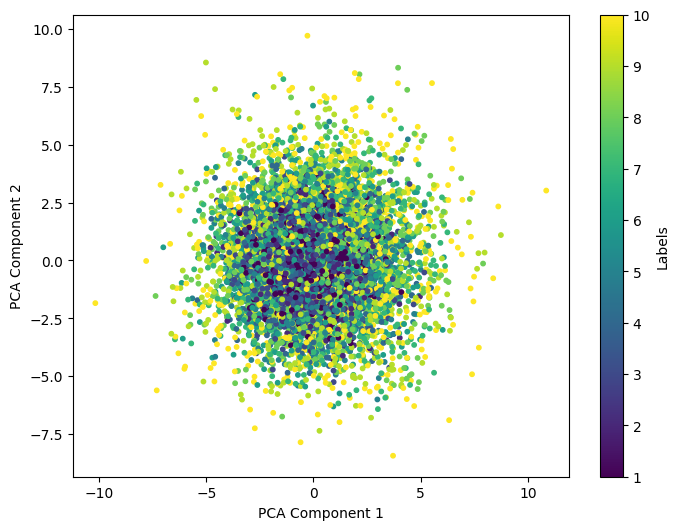

In [91]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
vae_jack.eval()

# Iterate over batches in train loader
for batch_data, batch_labels in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, mu, _ = vae_jack.encode(batch_data.to(device))
    
    # Append mu and labels to the respective lists
    latent_space_representations.append(mu.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.show()


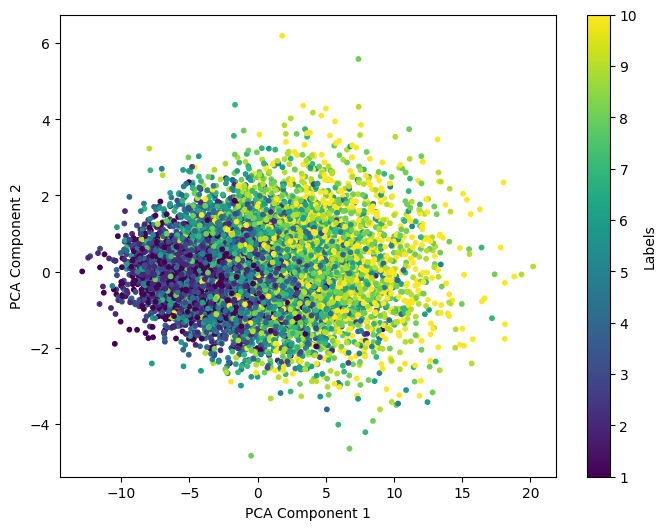

In [92]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
vae_jack.eval()

# Iterate over batches in train loader
for batch_data, batch_labels in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, _, logvar = vae_jack.encode(batch_data.to(device))
    
    # Append mu and labels to the respective lists
    latent_space_representations.append(logvar.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.show()


In [255]:
# pick an example
index = 400

# get original image and locations/states to compare
orig = dataset.data[index].unsqueeze(0)
orig_locations = dataset.locations[index]
orig_states = dataset.states[index]

# re-create image and send to cpu
gen = vae(orig)[0]
gen = gen.to("cpu").detach()[0]

# round generated to nearest integer
gen[gen < 0] = 0
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 2)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
count = 0
radius = 2.5    # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(gen[i,j,k]):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * dx + radius * math.cos(theta)
                gen_locations[count,1] = k * dx + radius * math.sin(theta)
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("gen_vae_2000.png", make_image(gen_locations, gen_states))

True

In [19]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
model = Predictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# split data for evalulating parameter predictor
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [22]:
# set to eval to get embedding
vae.eval()
vae.requires_grad = False

# train parameter predictor
epochs = 400
for epoch in range(epochs):
    for idx, (original, labels) in enumerate(train_loader):
        # run through trained VAE model
        generated, mu, logvar = vae(original)
        merge = torch.cat((mu, logvar), axis=1)

        # predict the parameter and compute loss
        predicted = model(merge)
        loss = torch.sum((predicted - labels)**2)

        # update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss/len(generated)):.3f}")

Epoch[1/40] Loss: 14.650
Epoch[2/40] Loss: 18.439
Epoch[3/40] Loss: 15.420
Epoch[4/40] Loss: 11.250
Epoch[5/40] Loss: 17.023
Epoch[6/40] Loss: 21.447
Epoch[7/40] Loss: 10.351
Epoch[8/40] Loss: 17.056
Epoch[9/40] Loss: 19.866
Epoch[10/40] Loss: 10.512
Epoch[11/40] Loss: 17.098
Epoch[12/40] Loss: 7.055
Epoch[13/40] Loss: 16.771
Epoch[14/40] Loss: 17.460
Epoch[15/40] Loss: 25.621
Epoch[16/40] Loss: 3.145
Epoch[17/40] Loss: 11.960
Epoch[18/40] Loss: 13.518
Epoch[19/40] Loss: 14.551
Epoch[20/40] Loss: 18.334
Epoch[21/40] Loss: 14.281
Epoch[22/40] Loss: 16.191
Epoch[23/40] Loss: 17.494
Epoch[24/40] Loss: 12.036
Epoch[25/40] Loss: 10.096
Epoch[26/40] Loss: 12.920
Epoch[27/40] Loss: 8.707
Epoch[28/40] Loss: 19.354
Epoch[29/40] Loss: 23.076
Epoch[30/40] Loss: 23.730
Epoch[31/40] Loss: 19.753
Epoch[32/40] Loss: 11.360
Epoch[33/40] Loss: 26.322
Epoch[34/40] Loss: 11.137
Epoch[35/40] Loss: 9.856
Epoch[36/40] Loss: 17.076
Epoch[37/40] Loss: 22.250
Epoch[38/40] Loss: 9.344
Epoch[39/40] Loss: 20.132


In [23]:
torch.save(model.state_dict(), "model.pt")

In [24]:
model = Predictor().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [27]:
# set to eval
vae.eval()
model.eval()

# create holder for true/predicted
n = len(dataset)
compare = torch.zeros(3, n)

# get true parameter values
compare[0] = torch.flatten(dataset.labels.to("cpu").detach())

# get predicted parameter values
generated, z, mu, logvar = vae(dataset.data)
merge = torch.cat((mu, logvar), axis=1)
compare[1] = torch.flatten(model(merge).to("cpu").detach())

# indicate if from test or train
compare[2][train_dataset.indices] = 0
compare[2][test_dataset.indices] = 1

# create dataframe for plotting with seaborn
df = pd.DataFrame(compare.numpy().T)
df.columns =["expect", "predict", "dataset"]
df["expect"] = df["expect"].astype(int)

In [ ]:
# number of parameter classes
groups = 10

# create figure
fig, ax = plt.subplots()

# make violin plot for test and train
sns.violinplot(data=df,
               x="expect",
               y="predict",
               hue="dataset",
               split=True,
               inner=None,
               linewidth=0)

# add labels
plt.legend(labels=["Train", "Test"], loc="lower right")
plt.plot([0, groups-1], [1, groups], "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# spatial-VAE Model

In [196]:
class ResidLinear(nn.Module):
    def __init__(self, n_in, n_out, activation=nn.Tanh):
        super(ResidLinear, self).__init__()
        self.linear = nn.Linear(n_in, n_out)
        self.act = activation()

    def forward(self, x):
        return self.act(self.linear(x) + x)

class InferenceNetwork(nn.Module):
    def __init__(self, n, latent_dim, hidden_dim, num_layers=1, activation=nn.Tanh, resid=True):
        super(InferenceNetwork, self).__init__()
        self.latent_dim = latent_dim
        self.n = n

        layers = [nn.Linear(2*n*n, hidden_dim), activation()]
        for _ in range(1, num_layers):
            if resid:
                layers.append(ResidLinear(hidden_dim, hidden_dim, activation=activation))
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(activation())
        layers.append(nn.Linear(hidden_dim, 2 * latent_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # reformat x as the inference network expects
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(-1, 2500, 2)
        x = x.reshape(x.size(0), -1)
        
        z = self.layers(x)
        ld = self.latent_dim
        z_mu = z[:, :ld]
        z_logstd = z[:, ld:]
        return z_mu, z_logstd

class SpatialGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_out=2, num_layers=1, activation=nn.Tanh, softplus=False, resid=True, expand_coords=False, bilinear=True):
        super(SpatialGenerator, self).__init__()

        self.softplus = softplus
        self.expand_coords = expand_coords
        in_dim = 2
        if expand_coords:
            in_dim = 5
        
        self.coord_linear = nn.Linear(in_dim, hidden_dim)
        self.latent_dim = latent_dim
        if latent_dim > 0:
            self.latent_linear = nn.Linear(latent_dim, hidden_dim, bias=False)

        if latent_dim > 0 and bilinear:
            self.bilinear = nn.Bilinear(in_dim, latent_dim, hidden_dim, bias=False)

        layers = [activation()]
        for _ in range(1, num_layers):
            if resid:
                layers.append(ResidLinear(hidden_dim, hidden_dim, activation=activation))
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(activation())
        layers.append(nn.Linear(hidden_dim, n_out))
        self.layers = nn.Sequential(*layers)

    def forward(self, x, z):
        b = x.size(0)
        n = x.size(1)
        x = x.reshape(b * n, -1)
        
        if self.expand_coords:
            x2 = x ** 2
            xx = x[:, 0] * x[:, 1]
            x = torch.cat([x, x2, xx.unsqueeze(1)], 1)

        h_x = self.coord_linear(x.to(device))
        h_x = h_x.view(b, n, -1)

        h_z = 0
        if hasattr(self, 'latent_linear'):
            if len(z.size()) < 2:
                z = z.unsqueeze(0)
            h_z = self.latent_linear(z)
            h_z = h_z.unsqueeze(1)

        h_bi = 0
        if hasattr(self, 'bilinear'):
            if len(z.size()) < 2:
                z = z.unsqueeze(0)
            z = z.unsqueeze(1)
            x = x.view(b, n, -1).to(device)
            z = z.expand(b, x.size(1), z.size(2)).contiguous()
            h_bi = self.bilinear(x, z)

        h = h_x + h_z + h_bi
        h = h.view(b * n, -1)

        y = self.layers(h)
        y = y.view(b, n, -1)

        if self.softplus:
            y = torch.cat([F.softplus(y[:, :, :1]), y[:, :, 1:]], 2)

        return y

In [197]:
class spatialVAE(nn.Module):
    def __init__(self, latent_dim=16, hidden_dim=500, n=50, num_layers=2, activation=nn.Tanh, resid=True, softplus=False, expand_coords=False, bilinear=True):
        super(spatialVAE, self).__init__()
        self.encoder = InferenceNetwork(n=n, latent_dim=latent_dim + 1, hidden_dim=hidden_dim, 
                                        num_layers=num_layers, activation=activation, resid=resid)

        self.decoder = SpatialGenerator(latent_dim=latent_dim, hidden_dim=hidden_dim, n_out=2, 
                                        num_layers=num_layers, activation=activation, softplus=softplus,
                                        resid=resid, expand_coords=expand_coords, bilinear=bilinear)
   
    def reparameterize(self, x, mu, logvar):
        # draw samples from variational posterior to calculate
        # E[p(x|z)]
        r = Variable(x.data.new(x.size(0), 17).normal_())
        std = torch.exp(logvar)
        z = std*r + mu
        return z, std

    def encode(self, x):
        mu, logvar = self.encoder(x)
        z, std = self.reparameterize(x, mu, logvar)
        return z, mu.to(device), logvar.to(device), std.to(device)
        
    def decode(self, x, rotated, z, mu, logvar, std):        
        # z[0] is the rotation
        theta_mu = mu[:,0]
        theta_std = std[:,0]
        theta_logvar = logvar[:,0]
        theta = z[:,0]
        z = z[:,1:]
        z_mu = mu[:,1:]
        z_std = std[:,1:]
        z_logvar = logvar[:,1:]

        kl_div = 0
        b = z.size(0)
        
        # x coordinate array
        xgrid = np.linspace(-1, 1, 50)
        ygrid = np.linspace(-1, 1, 50)
        x0,x1 = np.meshgrid(xgrid, ygrid)
        x_coord = np.stack([x0.ravel(), x1.ravel()], 1)
        x_coord = torch.from_numpy(x_coord).float()
        x_coord = x_coord.expand(b, x_coord.size(0), x_coord.size(1)).to(device)
     
        # calculate rotation matrix
        x_rot = torch.bmm(x_coord, rotated) # apply rotation
        z = self.decoder(x_rot, z)

        # use modified KL for rotation with no penalty on mean
        sigma = theta_prior = 0.34 # 20 degrees in radians
        kl_div = -theta_logvar + np.log(sigma) + theta_std**2/2/sigma**2 - 0.5
        
        return z, kl_div, z_mu, z_logvar, z_std

    def forward(self, x, rotated):
        z, mu, logvar, std = self.encode(x)
        z, kl_div, z_mu, z_logvar, z_std = self.decode(x, rotated, z, mu, logvar, std)
        return z, mu, logvar, std, kl_div, z_mu, z_logvar, z_std

In [198]:
from torchinfo import summary

sv = spatialVAE().to(device)
summary(sv, input_data = (torch.randn(128, 2, 50, 50).to(device), torch.randn(128, 2, 2).to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
spatialVAE                               [128, 2500, 2]            --
├─InferenceNetwork: 1-1                  [128, 17]                 --
│    └─Sequential: 2-1                   [128, 34]                 --
│    │    └─Linear: 3-1                  [128, 500]                2,500,500
│    │    └─Tanh: 3-2                    [128, 500]                --
│    │    └─ResidLinear: 3-3             [128, 500]                250,500
│    │    └─Linear: 3-4                  [128, 34]                 17,034
├─SpatialGenerator: 1-2                  [128, 2500, 2]            --
│    └─Linear: 2-2                       [320000, 500]             1,500
│    └─Linear: 2-3                       [128, 500]                8,000
│    └─Bilinear: 2-4                     [128, 2500, 500]          16,000
│    └─Sequential: 2-5                   [320000, 2]               --
│    │    └─Tanh: 3-5                    [320000, 500]     

In [199]:
spatial_vae = spatialVAE().to(device)
optimizer = torch.optim.Adam(spatial_vae.parameters(), lr=1e-4)

In [200]:
def loss_fn(z, original, mu, logvar, std, kl_div, b):

    y = original.permute(0, 2, 3, 1)
    y = y.reshape(y.size(0), -1, 2)
    y_hat = z.view(b, -1, 2)
    size = y.size(1)*2
    log_p_x_g_z = -F.binary_cross_entropy_with_logits(y_hat, y)*size

    # unit normal prior over z and translation
    kl = -logvar + 0.5*std**2 + 0.5*mu**2 - 0.5
    kl_div = kl_div + torch.sum(kl, 1)
    kl_div = kl_div.mean()
    
    elbo = log_p_x_g_z - kl_div
        
    return elbo, log_p_x_g_z, kl_div

In [201]:
%%time

# send to device and turn on training
spatial_vae.train()
# training vae
epochs = 100

for epoch in range(epochs):
    for idx, (original, _, rotated) in enumerate(train_loader):            

        if idx > 0:
            # setup variables
            b = original.size(0)
            c = 0
            gen_loss_accum = 0
            kl_loss_accum = 0
            elbo_accum = 0
            
            # run through vae and measure loss with MSE
            z, mu, logvar, std, kl_div, z_mu, z_logvar, z_std = spatial_vae(original, rotated.float().to(device))
            elbo, log_p_x_g_z, kl_div = loss_fn(z, original, z_mu, z_logvar, z_std, kl_div, b)
            
            # update vae
            loss = -elbo
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
            # print loss
            elbo = elbo.item()
            gen_loss = -log_p_x_g_z.item()
            kl_loss = kl_div.item()
    
            c += b
            delta = b*(gen_loss - gen_loss_accum)
            gen_loss_accum += delta/c
    
            delta = b*(elbo - elbo_accum)
            elbo_accum += delta/c
    
            delta = b*(kl_loss - kl_loss_accum)
            kl_loss_accum += delta/c

    if epoch % 10 == 0:
        torch.save(spatial_vae.state_dict(), f"spatial_vae_lt.pt")
        print(f"Epoch[{epoch+1}/{epochs}] ELBO: {elbo_accum:.3f}, Error: {gen_loss_accum:.3f}, KL: {kl_loss_accum:.3f}")

Epoch[1/100] ELBO: -1352.398, Error: 1293.423, KL: 58.975
Epoch[2/100] ELBO: -772.798, Error: 710.781, KL: 62.017
Epoch[3/100] ELBO: -714.339, Error: 661.108, KL: 53.231
Epoch[4/100] ELBO: -679.887, Error: 630.521, KL: 49.366
Epoch[5/100] ELBO: -664.501, Error: 617.189, KL: 47.311
Epoch[6/100] ELBO: -672.503, Error: 626.783, KL: 45.720
Epoch[7/100] ELBO: -636.229, Error: 592.528, KL: 43.702
Epoch[8/100] ELBO: -627.680, Error: 586.236, KL: 41.444
Epoch[9/100] ELBO: -613.757, Error: 574.003, KL: 39.754
Epoch[10/100] ELBO: -643.642, Error: 606.148, KL: 37.495
Epoch[11/100] ELBO: -617.684, Error: 581.437, KL: 36.246
Epoch[12/100] ELBO: -605.801, Error: 571.079, KL: 34.722
Epoch[13/100] ELBO: -610.720, Error: 577.436, KL: 33.284
Epoch[14/100] ELBO: -585.049, Error: 552.745, KL: 32.303
Epoch[15/100] ELBO: -594.852, Error: 563.451, KL: 31.401
Epoch[16/100] ELBO: -594.370, Error: 564.543, KL: 29.827
Epoch[17/100] ELBO: -606.260, Error: 578.335, KL: 27.925
Epoch[18/100] ELBO: -589.735, Error: 5

In [177]:
# spatial_vae = spatialVAE().to(device)
# spatial_vae.load_state_dict(torch.load("spatial_vae.pt"))

<All keys matched successfully>

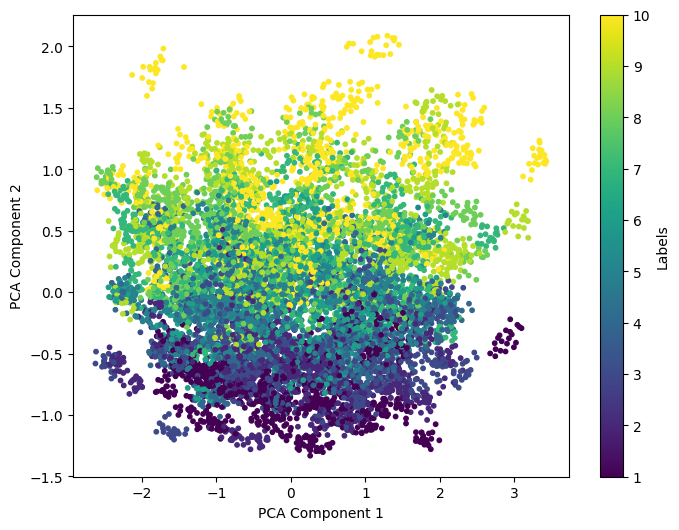

In [202]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
spatial_vae.eval()

# Iterate over batches in train loader
for batch_data, batch_labels, _ in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, mu, _, _ = spatial_vae.encode(batch_data.to(device))
    
    # Append mu and labels to the respective lists
    latent_space_representations.append(mu.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.show()


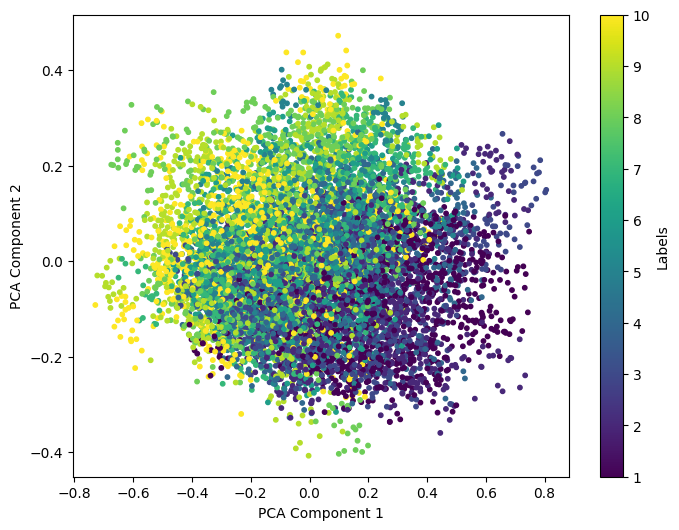

In [203]:
from sklearn.decomposition import PCA

# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
labels = []

# Set VAE model to evaluation mode
spatial_vae.eval()

# Iterate over batches in train loader
for batch_data, batch_labels, _ in train_loader:
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, _, logvar, _ = spatial_vae.encode(batch_data.to(device))
    
    # Append mu and labels to the respective lists
    latent_space_representations.append(logvar.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
labels_array = np.concatenate(labels, axis=0)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.show()

In [204]:
# pick an example
index = 400

# get original image and locations/states to compare
orig = dataset.data[index].unsqueeze(0)
orig_locations = dataset.locations[index]
orig_states = dataset.states[index]
orig_rotated = torch.tensor(dataset.rotated[index]).float().to(device).unsqueeze(dim = 0)

# re-create image and send to cpu
z = spatial_vae(orig, orig_rotated)[0]
gen = z.view(1, 50, 50, 2)
gen = gen.permute(0, 3, 1, 2)
gen = gen.to("cpu").detach()[0]

# round generated to nearest integer
gen[gen < 0] = 0
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 2)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
count = 0
radius = 2.5    # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(gen[i,j,k]):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * dx + radius * math.cos(theta)
                gen_locations[count,1] = k * dx + radius * math.sin(theta)
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("gen_spatial_lt.png", make_image(gen_locations, gen_states))

True

In [233]:
# pick an example
index = 3

# get original image and locations/states to compare
orig = dataset.data[index].unsqueeze(0)
orig_locations = dataset.locations[index]
orig_states = dataset.states[index]
orig_rotated = torch.tensor(dataset.rotated[index]).float().to(device).unsqueeze(dim = 0)

# re-create image and send to cpu
z = spatial_vae(orig, orig_rotated)[0]
gen = z.view(1, 50, 50, 2)
gen = gen.permute(0, 3, 1, 2)
gen = gen.to("cpu").detach()[0]

# round generated to nearest integer
gen[gen < 0] = 0
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 2)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
count = 0
radius = 2.5    # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(gen[i,j,k]):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * dx + radius * math.cos(theta)
                gen_locations[count,1] = k * dx + radius * math.sin(theta)
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("gen_spatial_3.png", make_image(gen_locations, gen_states))

True